# Seminar 1 - SQL and data cleaning on the attendance dataset

This notebook is more about illustrating the process of thinking, rather than doing the analysis the correct way or presenting some results.



In [2]:
import duckdb

## Step 1 - look at data

The first step when facing some new data is to look at it. This is something that applies always, regardless of what problem you're facing - look at your data. Let's look at each dataset in turn.

Here are some best practices:
- It's always a good idea to look at a random sample of the data, rather than the first/last N rows.
- Begin with small tables first (in our case, `school` and `subject`) - tables that are about a single thing - rather than bigger tables that are a combination of multiple things.


## school

In [3]:
duckdb.sql(
    "SELECT * FROM 'attendance/school.parquet' ORDER BY random() LIMIT 10"
).show()

┌─────────────────┬─────────────┬───────────────┬────────────────────────────────────────────────┬───────────────┬───────────────────┬───────────────────┐
│    unique_id    │ school_code │ division_code │                  school_name                   │ division_name │ municipality_code │ municipality_name │
│     varchar     │    int64    │    varchar    │                    varchar                     │    varchar    │       int64       │      varchar      │
├─────────────────┼─────────────┼───────────────┼────────────────────────────────────────────────┼───────────────┼───────────────────┼───────────────────┤
│ 7c5e3424ced105c │   190283613 │ NULL          │ Kretingos r. Vydmantų gimnazija                │ NULL          │                56 │ Kretingos r. sav. │
│ 6e131d66e2c9a50 │   190360892 │ NULL          │ Širvintų Lauryno Stuokos-Gucevičiaus gimnazija │ NULL          │                89 │ Širvintų r. sav.  │
│ 669e18a1c909445 │   191131028 │ NULL          │ Plungės r. Kulių gim

`school_code` should be the primary key in this table. Primary key is a column (or several columns) by which a unique row in the table is identified. By stating that `school_code` is a primary key, I explicitly expect two things from the column:
- This column has no duplicate values.
- This column has no null values.

Let's verify these assumptions.

In [4]:
duckdb.sql(
    """
    SELECT 
        school_code,
        COUNT(*)
    FROM 'attendance/school.parquet' 
    GROUP BY school_code
    HAVING COUNT(*) > 1
"""
).show()

┌─────────────┬──────────────┐
│ school_code │ count_star() │
│    int64    │    int64     │
├─────────────┼──────────────┤
│   190986889 │            2 │
│   190189861 │            2 │
│   191090275 │            2 │
│   191130983 │            2 │
│   190341810 │            2 │
│   195170434 │            2 │
│   295093070 │            2 │
│   190066944 │            2 │
│   191130079 │            2 │
│   302843970 │            2 │
│   191791956 │            2 │
│   190341625 │            2 │
│   190697735 │            2 │
│   190892856 │            2 │
│   190545880 │            3 │
│   290893610 │            2 │
│   190696786 │            2 │
├─────────────┴──────────────┤
│ 17 rows          2 columns │
└────────────────────────────┘



We have duplicates :/ Let's look at a couple of them.

In [5]:
duckdb.sql(
    """
    SELECT *
    FROM 'attendance/school.parquet'
    WHERE school_code IN (190341810, 191130983, 191130079)
"""
).show()

┌─────────────────┬─────────────┬───────────────┬─────────────────────────────────────────────┬─────────────────────────────────────────────────────────────────────┬───────────────────┬───────────────────┐
│    unique_id    │ school_code │ division_code │                 school_name                 │                            division_name                            │ municipality_code │ municipality_name │
│     varchar     │    int64    │    varchar    │                   varchar                   │                               varchar                               │       int64       │      varchar      │
├─────────────────┼─────────────┼───────────────┼─────────────────────────────────────────────┼─────────────────────────────────────────────────────────────────────┼───────────────────┼───────────────────┤
│ 33ba4eb90b8b20a │   190341810 │ 1446          │ Ukmergės Senamiesčio progimnazija           │ Ukmergės Senamiesčio progimnazijos Laičių pradinio ugdymo skyrius   │           

Looks like the school table is actually unique by school_code and division_code, but let's verify again

In [6]:
duckdb.sql(
    """
    SELECT 
        school_code,
        division_code,
        COUNT(*)
    FROM 'attendance/school.parquet' 
    GROUP BY school_code, division_code
    HAVING COUNT(*) > 1
"""
).show()

┌─────────────┬───────────────┬──────────────┐
│ school_code │ division_code │ count_star() │
│    int64    │    varchar    │    int64     │
├─────────────┴───────────────┴──────────────┤
│                   0 rows                   │
└────────────────────────────────────────────┘



This is a data quality issue - it's unclear what division code NULL means, and the table documentation makes it seems that this is data on schools and not school divisions.

I'll deal with it in a somewhat silly way - I'll remove cases where `division_code` is not null. This is essentially saying - I won't look at schools that have divisions. Ideally we wouldn't do this, but out of concern for time, let's make this simplification. Also only 17 `school_codes` have the duplicate issue.

Simplifying in the beginning of an analysis is a good approach to manage complexity. We still don't know the dataset very well, so let's simplify. Once we are more familiar with the data, we can increase complexity and make our analysis more "correct".

Let's check if there are no null `school_codes`.


In [7]:
duckdb.sql(
    """
    SELECT 
        count(distinct school_code),
        count(*)
    FROM 'attendance/school.parquet' 
    WHERE division_code IS NULL
"""
)

┌─────────────────────────────┬──────────────┐
│ count(DISTINCT school_code) │ count_star() │
│            int64            │    int64     │
├─────────────────────────────┼──────────────┤
│                         983 │          983 │
└─────────────────────────────┴──────────────┘

In [8]:
# Final query for the school table
school = """
    SELECT 
        school_code, 
        school_name, 
        municipality_name
    FROM 'attendance/school.parquet' 
    WHERE division_code IS NULL
"""
duckdb.sql(school + " LIMIT 10").show()

┌─────────────┬─────────────────────────────────────────────────┬─────────────────────┐
│ school_code │                   school_name                   │  municipality_name  │
│    int64    │                     varchar                     │       varchar       │
├─────────────┼─────────────────────────────────────────────────┼─────────────────────┤
│   190545880 │ Biržų „Aušros“ pagrindinė mokykla               │ Biržų r. sav.       │
│   191130264 │ Plungės „Saulės“ gimnazija                      │ Plungės r. sav.     │
│   191814839 │ Mažeikių „Žiburėlio“ pradinė mokykla            │ Mažeikių r. sav.    │
│   190507118 │ Švenčionių r. Adutiškio pagrindinė mokykla      │ Švenčionių r. sav.  │
│   191317260 │ Vilniaus Trakų Vokės gimnazija                  │ Vilniaus m. sav.    │
│   191709681 │ Vilniaus Jono Ivaškevičiaus jaunimo mokykla     │ Vilniaus m. sav.    │
│   290486810 │ Vilkaviškio rajono Pajevonio pagrindinė mokykla │ Vilkaviškio r. sav. │
│   303283300 │ Panevėžio Raimun

## subject


In [9]:
duckdb.sql(
    "SELECT * FROM 'attendance/subject.parquet' ORDER BY random() LIMIT 10"
).show()

┌─────────────────┬──────────────────┬──────────────┬────────────────────────────────────┬───────────────────────────────────┐
│    unique_id    │ electronic_diary │ subject_code │            subject_name            │          subject_name_en          │
│     varchar     │     varchar      │    int64     │              varchar               │              varchar              │
├─────────────────┼──────────────────┼──────────────┼────────────────────────────────────┼───────────────────────────────────┤
│ 2e4a313427a7573 │ Tamo             │         9103 │ Teatras                            │ Theater                           │
│ 357c7a0f6163e1e │ NASC             │         5301 │ Geografija                         │ Geography                         │
│ 80b6ca1f0eb0864 │ Tamo             │        10107 │ Mechanika, mechaninis remontas     │ Mechanics, mechanical repair      │
│ adcf56cc20c1397 │ NASC             │        24011 │ Simfoninis orkestras               │ Symphonic orchestra 

This table should be unique by `electronic_diary` and `subject_code`, let's check.


In [10]:
duckdb.sql(
    """
    SELECT
        electronic_diary,
        subject_code,
        COUNT(*)
    FROM 'attendance/subject.parquet'
    GROUP BY all
    HAVING COUNT(*) > 1
"""
).show()

┌──────────────────┬──────────────┬──────────────┐
│ electronic_diary │ subject_code │ count_star() │
│     varchar      │    int64     │    int64     │
├──────────────────┴──────────────┴──────────────┤
│                     0 rows                     │
└────────────────────────────────────────────────┘



In [11]:
# Final query for the subject table
subject = """
    SELECT
        electronic_diary,
        subject_code,
        subject_name_en,
    FROM 'attendance/subject.parquet'
"""


yay!

## attendance

In [12]:
duckdb.sql(
    "SELECT * FROM 'attendance/attendance.parquet' ORDER BY random() LIMIT 10"
).show()

┌─────────────────┬───────────────┬─────────────┬───────────────┬───────────────┬──────────────┬──────────────────┬───────────────────┬─────────────────────┬─────────────────────────┬───────────────────────┬───────────────────┐
│    unique_id    │ report_period │ school_code │ division_code │ student_class │ subject_code │ electronic_diary │ student_count_nsa │ student_count_diary │ excused_lessons_illness │ excused_lessons_other │ unexcused_lessons │
│     varchar     │     date      │    int64    │    varchar    │     int64     │    int64     │     varchar      │       int64       │        int64        │          int64          │         int64         │       int64       │
├─────────────────┼───────────────┼─────────────┼───────────────┼───────────────┼──────────────┼──────────────────┼───────────────────┼─────────────────────┼─────────────────────────┼───────────────────────┼───────────────────┤
│ 56df39d90ccc3f1 │ 2021-05-01    │   191414994 │ NULL          │             7 │       

- The rows in this table should be unique by `report_period`, `school_code`, `student_class` and `subject_code`. I should add `division_code` to this list, but I've already decided to not use that column. `electronic_diary` is not in this list because, if I remember correctly, each school uses just one of the diaries.
- `school_code` is the foreign key from the school table, while `subject_code` and `electronic_diary` are foreign keys, therefore I expect them to not have any NULL values.

Let's verify.


In [13]:
duckdb.sql(
    """
    SELECT 
        report_period,
        school_code,
        student_class,
        subject_code,
        COUNT(*)
    FROM 'attendance/attendance.parquet'
    WHERE division_code IS NULL
    GROUP BY all
    HAVING COUNT(*) > 1
"""
).show()

┌───────────────┬─────────────┬───────────────┬──────────────┬──────────────┐
│ report_period │ school_code │ student_class │ subject_code │ count_star() │
│     date      │    int64    │     int64     │    int64     │    int64     │
├───────────────┼─────────────┼───────────────┼──────────────┼──────────────┤
│ 2024-04-01    │   190438049 │             9 │         6001 │            2 │
│ 2024-11-01    │   191416283 │            10 │         8101 │            2 │
│ 2024-10-01    │   190438049 │             9 │         5301 │            2 │
│ 2024-12-01    │   190422397 │             6 │         5301 │            2 │
│ 2024-01-01    │   191832328 │             3 │         8402 │            2 │
│ 2024-10-01    │   190239620 │             9 │         6001 │            2 │
│ 2023-12-01    │   190034188 │             9 │         9101 │            2 │
│ 2024-01-01    │   290485480 │            10 │         6001 │            2 │
│ 2021-06-01    │   290469280 │             7 │         5101 │  

We have duplicates in the dataset again. But how many duplicates?

In [14]:
duckdb.sql(
    """
    SELECT 
        report_period,
        school_code,
        student_class,
        subject_code,
        COUNT(*)
    FROM 'attendance/attendance.parquet'
    WHERE division_code IS NULL
    GROUP BY all
    HAVING COUNT(*) > 1
    ORDER BY random()
"""
).df().shape

(18776, 5)

Quite a few duplicated rows. 

Maybe I should have also included `electronic_diary` among the columns by which the attendance table is unique? This is weird, because why would a single class in a single school use two diaries? But weird things happen.

In [15]:
duckdb.sql(
    """
    SELECT 
        report_period,
        school_code,
        division_code,
        student_class,
        subject_code,
        electronic_diary,
        COUNT(*)
    FROM 'attendance/attendance.parquet'
    WHERE division_code IS NULL
    GROUP BY all
    HAVING COUNT(*) > 1
    ORDER BY random()
"""
).df().shape

(12668, 7)

Ok, even grouping by `electronic_diary`, we have duplicates in the dataset. Let's look at several duplicated rows again.

In [16]:
duckdb.sql(
    """
    SELECT 
        report_period,
        school_code,
        division_code,
        student_class,
        subject_code,
        electronic_diary,
        COUNT(*)
    FROM 'attendance/attendance.parquet'
    WHERE division_code IS NULL
    GROUP BY all
    HAVING COUNT(*) > 1
    ORDER BY random()
    LIMIT 5
"""
).show()

┌───────────────┬─────────────┬───────────────┬───────────────┬──────────────┬──────────────────┬──────────────┐
│ report_period │ school_code │ division_code │ student_class │ subject_code │ electronic_diary │ count_star() │
│     date      │    int64    │    varchar    │     int64     │    int64     │     varchar      │    int64     │
├───────────────┼─────────────┼───────────────┼───────────────┼──────────────┼──────────────────┼──────────────┤
│ 2024-10-01    │   190139463 │ NULL          │            10 │         8101 │ NASC             │            2 │
│ 2024-04-01    │   191315786 │ NULL          │             8 │         4001 │ NASC             │            2 │
│ 2023-12-01    │   190006438 │ NULL          │            12 │         8101 │ NASC             │            2 │
│ 2023-12-01    │   191316888 │ NULL          │             5 │         8402 │ NASC             │            2 │
│ 2023-11-01    │   191411927 │ NULL          │             5 │         9102 │ NASC             

In [17]:
# Here I'm taking the first row from above and inserting the required values
duckdb.sql(
    """
    SELECT
        *
    FROM 'attendance/attendance.parquet'
    WHERE division_code IS NULL
    AND school_code = 290984490
    AND student_class = 1
    AND subject_code = 9101
    ORDER BY report_period
"""
)

┌─────────────────┬───────────────┬─────────────┬───────────────┬───────────────┬──────────────┬──────────────────┬───────────────────┬─────────────────────┬─────────────────────────┬───────────────────────┬───────────────────┐
│    unique_id    │ report_period │ school_code │ division_code │ student_class │ subject_code │ electronic_diary │ student_count_nsa │ student_count_diary │ excused_lessons_illness │ excused_lessons_other │ unexcused_lessons │
│     varchar     │     date      │    int64    │    varchar    │     int64     │    int64     │     varchar      │       int64       │        int64        │          int64          │         int64         │       int64       │
├─────────────────┼───────────────┼─────────────┼───────────────┼───────────────┼──────────────┼──────────────────┼───────────────────┼─────────────────────┼─────────────────────────┼───────────────────────┼───────────────────┤
│ 047c0a11c721ffe │ 2015-11-01    │   290984490 │ NULL          │             1 │       

It seems that in this case we just have duplicated rows. Here's what I'm noticing:
- for the duplicated rows, values in columns `student_count_diary` and `student_count_nsa` are the same.
- Values for the other columns (`excused_lessons_illness` etc.) are usually different. 

To solve the problem of duplicates in this table, I'll just aggregated by the columns that 

In [18]:
attendance = """
    SELECT
        report_period,
        school_code,
        student_class,
        subject_code,
        electronic_diary,
        FIRST(student_count_diary) student_count_diary,
        SUM(excused_lessons_illness) excused_lessons_illness,
        SUM(excused_lessons_other) excused_lessons_other,
        SUM(unexcused_lessons) unexcused_lessons
    FROM 'attendance/attendance.parquet'
    WHERE division_code IS NULL
    GROUP BY all
"""
duckdb.sql(attendance + " LIMIT 10").show()

┌───────────────┬─────────────┬───────────────┬──────────────┬──────────────────┬─────────────────────┬─────────────────────────┬───────────────────────┬───────────────────┐
│ report_period │ school_code │ student_class │ subject_code │ electronic_diary │ student_count_diary │ excused_lessons_illness │ excused_lessons_other │ unexcused_lessons │
│     date      │    int64    │     int64     │    int64     │     varchar      │        int64        │         int128          │        int128         │      int128       │
├───────────────┼─────────────┼───────────────┼──────────────┼──────────────────┼─────────────────────┼─────────────────────────┼───────────────────────┼───────────────────┤
│ 2020-11-01    │   190009733 │            12 │         4001 │ Tamo             │                 122 │                       0 │                    69 │                10 │
│ 2025-01-01    │   190192277 │             8 │        10100 │ NASC             │                  12 │                       0 │ 

I now have a dataset that I am sure is unique by `report_period`, `school_code`, `student_class` and `subject_code`, `electronic_diary` because that's how GROUP BY works.


## final query

Ok, I think I'm ready to work on the final dataset now, so let's join everything together. I saved my queries into Python variables for a reason - now combining them is very easy. 

Keep in mind, that below I'm only using the WITH statement and inserting the tables separately because to all of them except the `subject` table I had to apply some sort of deduplication or grouping - logic that I now want to end up in the final query as well.

Also note how big the final query is - that's a lot of logic! It would have been very tricky to such a query from the get go. That's why we went through this iterative process in the seminar.


In [19]:
query = f"""
WITH attendance AS ({attendance}),
    school AS ({school}),
    subject AS ({subject})
SELECT
    school.school_name,
    school.school_code,
    school.municipality_name,
    attendance.student_class,
    attendance.report_period,
    subject.subject_name_en,
    attendance.student_count_diary,
    attendance.excused_lessons_illness,
    attendance.excused_lessons_other,
    attendance.unexcused_lessons
FROM attendance
JOIN school ON attendance.school_code = school.school_code
JOIN subject ON attendance.subject_code = subject.subject_code
    AND attendance.electronic_diary = subject.electronic_diary
"""
print(query)


WITH attendance AS (
    SELECT
        report_period,
        school_code,
        student_class,
        subject_code,
        electronic_diary,
        FIRST(student_count_diary) student_count_diary,
        SUM(excused_lessons_illness) excused_lessons_illness,
        SUM(excused_lessons_other) excused_lessons_other,
        SUM(unexcused_lessons) unexcused_lessons
    FROM 'attendance/attendance.parquet'
    WHERE division_code IS NULL
    GROUP BY all
),
    school AS (
    SELECT 
        school_code, 
        school_name, 
        municipality_name
    FROM 'attendance/school.parquet' 
    WHERE division_code IS NULL
),
    subject AS (
    SELECT
        electronic_diary,
        subject_code,
        subject_name_en,
    FROM 'attendance/subject.parquet'
)
SELECT
    school.school_name,
    school.school_code,
    school.municipality_name,
    attendance.student_class,
    attendance.report_period,
    subject.subject_name_en,
    attendance.student_count_diary,
    attendan

In [20]:
df = duckdb.sql(query).df()


## Some plots

So what can we do with the table? Here's some random plots

In [21]:
df_uzupis = df[
    (df["subject_name_en"] == "Mathematics") &
    (df["student_class"] == 12) &
    (df["report_period"] >= "2018-01-01") &
    (df["report_period"] <= "2024-12-31") &
    (df["school_name"].str.contains("Užupio")) # My school
]


In [22]:
df_uzupis["excused_illness_per_student"] = df_uzupis["excused_lessons_illness"] / df_uzupis["student_count_diary"]
df_uzupis["excused_other_per_student"] = df_uzupis["excused_lessons_other"] / df_uzupis["student_count_diary"]
df_uzupis["unexcused_per_student"] = df_uzupis["unexcused_lessons"] / df_uzupis["student_count_diary"]



/var/folders/q2/xtfjmccj47v4wbsjvxymw5b00000gp/T/ipykernel_63824/3687969839.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uzupis["excused_illness_per_student"] = df_uzupis["excused_lessons_illness"] / df_uzupis["student_count_diary"]
/var/folders/q2/xtfjmccj47v4wbsjvxymw5b00000gp/T/ipykernel_63824/3687969839.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uzupis["excused_other_per_student"] = df_uzupis["excused_lessons_other"] / df_uzupis["student_count_diary"]
/var/folders/q2/xtfjmccj47v4wb

In [27]:
# We can get rid of the warnings above by using the following code (they will disappear if you run the code above again)
import pandas as pd
pd.options.mode.chained_assignment = None  # Suppress the SettingWithCopyWarning


<Axes: xlabel='report_period'>

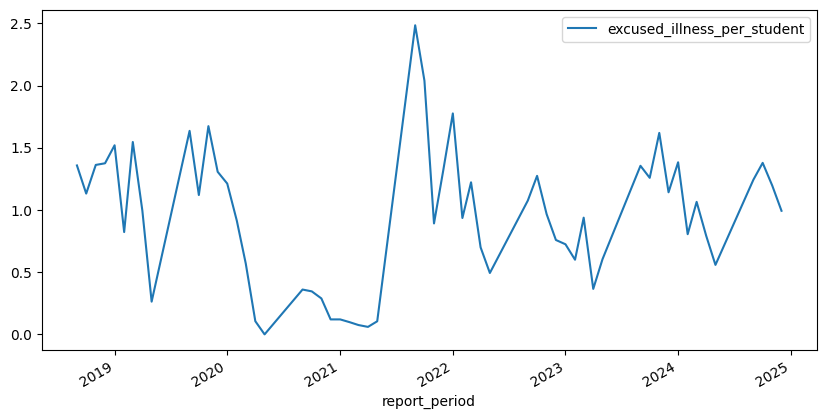

In [28]:
df_uzupis.sort_values(by="report_period").plot.line(x="report_period", y="excused_illness_per_student", figsize=(10, 5))

<Axes: xlabel='report_period'>

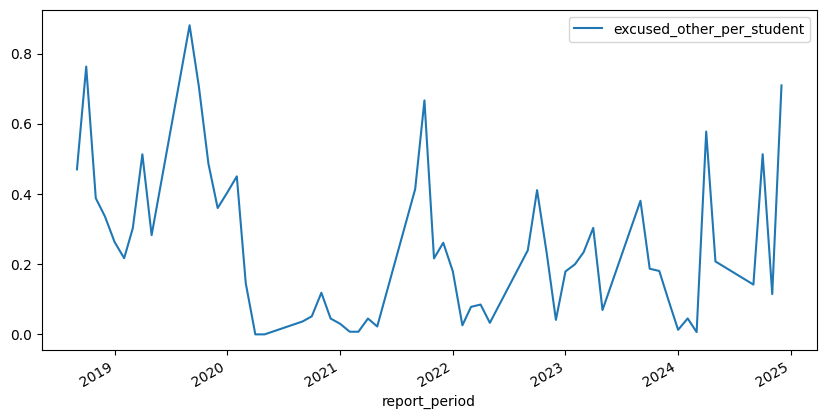

In [29]:
df_uzupis.sort_values(by="report_period").plot.line(x="report_period", y="excused_other_per_student", figsize=(10, 5))


<Axes: xlabel='report_period'>

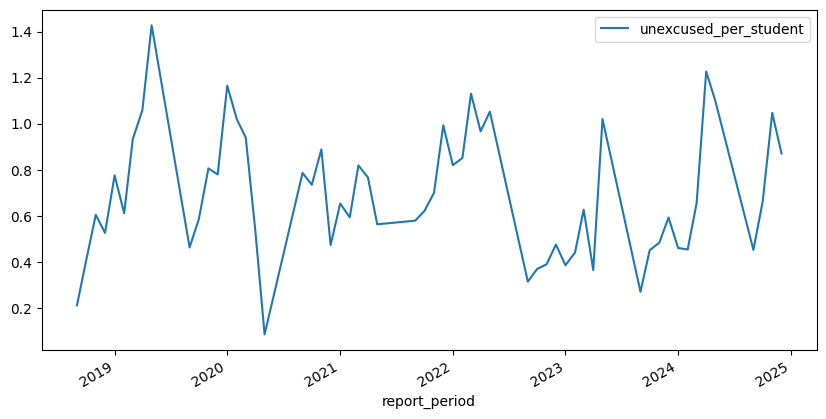

In [30]:
df_uzupis.sort_values(by="report_period").plot.line(x="report_period", y="unexcused_per_student", figsize=(10, 5))


## Recap

- While looking at the data (documentation and some random rows), make sure to identify what you are expecting of assuming of the table, and verify those assumptions.
- We spent a lot of time on investigating data quality issues here. You do not need to be that extensive for the homework, just make sure that your data is clean given the questions that you want to answer.
- We need to make sure that our primary keys are unique, otherwise we risk creating duplicates via many-to-many joins.
